In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(directory['py'])
import techdata_to_tree, sys, ShockFunction
import abatement_ID_calib as abatement
os.chdir(directory['curr'])
# from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import NullFormatter
from cycler import cycler
import warnings
colors = "#1f77b4 #ff770e #2ca02c #d62728".split()
plt.rcParams.update({"axes.prop_cycle":cycler(color=colors)})

The file_gams_py_gdb1.gdx is still active and was not deleted.
The file_gams_py_gdb2.gdx is still active and was not deleted.
The file_gams_py_gdb4.gdx is still active and was not deleted.


## A rising price of emissions (oil) (drawing the figures)
We present graphically what happens when the oil price gradually increases (static model solution for each price).
For this, we again use the sneaky solve, but we make sure to extract variables of interest for each iteration, in contrast to above where we were not interested in the solutions per se, but simply that the values of $\sigma$ ended in the desired spots.

In [2]:
# dfEOP = pd.read_csv("EOP_df.csv").set_index("pM")
# dfID = pd.read_csv("ID_df.csv").set_index("pM")

In [12]:
#START HER MED NYE FIGURER FRA PICKLES.
x_var = "pM"
catalog = "techdata_adv"
with (open(x_var + "_" + catalog + ".pkl", "rb")) as f:
    df = pickle.load(f)

In [13]:
def translate(col):    
    translate = {
        "M0":"Emissions",
        "pM":"Price of emissions",
        "PwThat_basetech_EL_oil":"Effective oil price",
        "qD_basetech_EL_oil":"Oil use",
        "qD_basetech_EL_electricity":"Electricity use",
        "qD_U0_ID_C_EL_1":"Baseline technology",
        "qD_U_ID_t2_1":"Clean technology",
        "qD_EL":"Energy service",
        "qD_Y":"Y composite",
        "M0_CO2":"CO2 Emissions"
    }
    if col in translate:
        return translate[col]
    else:
        return col

def format_double_axes(ax, ax2, x_label="", y_label="", hide_ticks=True):
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20, rotation=0)
    ax.yaxis.set_label_coords(0.1,1.02)
    if hide_ticks:
        ax.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["left"].set_edgecolor("k")
    ax.spines["bottom"].set_edgecolor("k")
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax2.grid(False)
    #ax.set_axisbelow(True)
    ax.grid(axis='y', color="lightgrey", linewidth=0.2)
    ax.get_yaxis().set_major_formatter(NullFormatter())

def format_single_axis(axes, x_label="", y_label="", hide_ticks=True):
    axes.set_xlabel(x_label, fontsize=20)
    axes.set_ylabel(y_label, fontsize=20, rotation=0)
    axes.yaxis.set_label_coords(0.1,1.02)
    if hide_ticks:
        axes.get_xaxis().set_ticks([])
#     axes.get_yaxis().set_ticks([])
    axes.spines["left"].set_visible(True)
    axes.spines["bottom"].set_visible(True)
    axes.spines["left"].set_linewidth(0.5)
    axes.spines["left"].set_edgecolor("k")
    axes.spines["bottom"].set_edgecolor("k")
    axes.spines["bottom"].set_linewidth(0.5)
    axes.spines["right"].set_visible(False)
    axes.spines["top"].set_visible(False)
    #axes.set_axisbelow(True)
    axes.grid(axis='y', color="lightgrey", linewidth=0.2)
    axes.get_yaxis().set_major_formatter(NullFormatter())
    

In [28]:
vlines = df[["PwThat_ID_t2"]].mean().to_list()

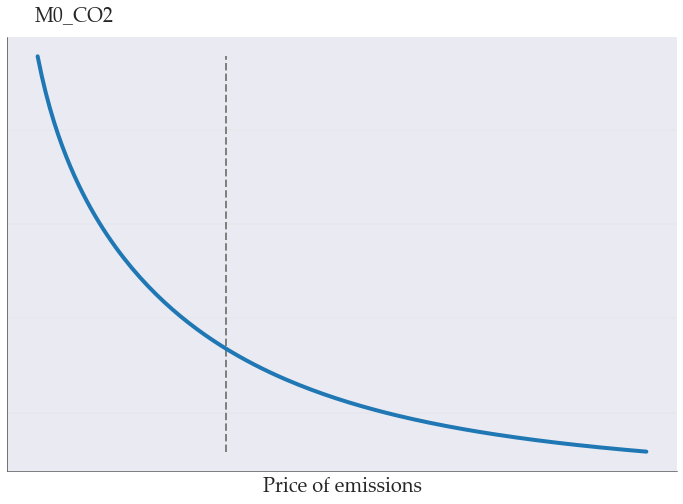

In [30]:
#Emission figure
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 1, 1)
ax = fig.get_axes()[0]
if "M0" in df.columns:
    col = "M0"
elif "M0_CO2" in df.columns:
    col = "M0_CO2"
with warnings.catch_warnings():
    warnings.simplefilter("ignore") #Otherwise throws warning if the column is named "M"
    ax.plot(df.index, col, color=colors[0], data=df, label=translate(col), linewidth=4)
ax.vlines(x=vlines, ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2)
format_single_axis(ax, x_label=translate(df.index.name), y_label=translate(col))
fig.savefig("Emissions_" + catalog + ".pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')

In [31]:
del fig, ax

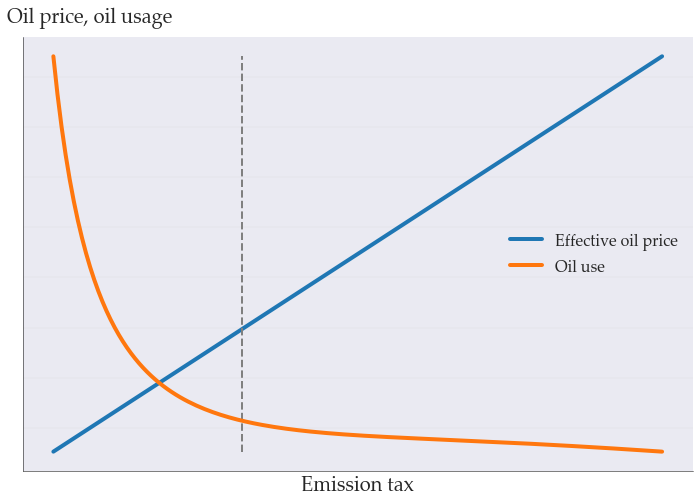

In [32]:
#Figure with oil price and oil usage
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 1, 1)
ax = fig.get_axes()[0]
col = "PwThat_basetech_EL_oil"
assert col in df.columns
ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[0])
ax2 = ax.twinx()
col = "qD_basetech_EL_oil"
ax2.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[1])
lines, labels = ax.get_legend_handles_labels()
lines = lines + ax2.get_legend_handles_labels()[0]
labels = labels + ax2.get_legend_handles_labels()[1]
ax.legend(lines, labels, fontsize=16, loc="right")
ax2.vlines(x=vlines, ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2)
format_double_axes(ax, ax2, "Emission tax", "Oil price, oil usage")
fig.savefig("oil_" + catalog + ".pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')
del fig, ax, ax2


Figure showing quantities in the MNL nest where the technology and the baseline compete

In [33]:
t = abs(df["PwThat_U_ID_t2_1"] - df["PwThat_U0_ID_C_EL_1"]) == abs(df["PwThat_U_ID_t2_1"] - df["PwThat_U0_ID_C_EL_1"]).min()
vlines = list(t[t].index.values)

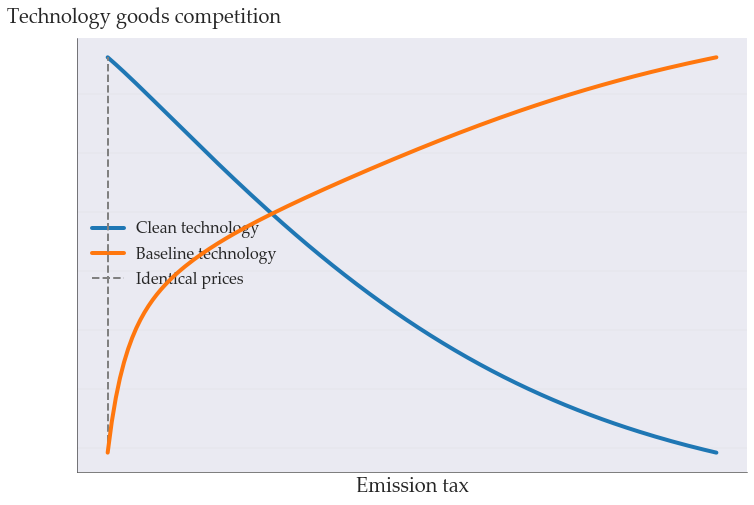

In [34]:
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 1, 1)
ax = fig.get_axes()[0]
col = "qD_U_ID_t2_1"
assert col in df.columns
ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[0])
ax2 = ax.twinx()
col = "qD_U0_ID_C_EL_1"
assert col in df.columns
ax2.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[1])
ax2.vlines(x=vlines, ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2, label="Identical prices")
lines, labels = ax.get_legend_handles_labels()
lines = lines + ax2.get_legend_handles_labels()[0]
labels = labels + ax2.get_legend_handles_labels()[1]
ax.legend(lines, labels, fontsize=16, loc="center left")
format_double_axes(ax, ax2, "Emission tax", "Technology goods competition")
fig.savefig("Technology_goods_competition_" + catalog + ".pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')
del fig, ax, ax2

Figure showing EL and Y 

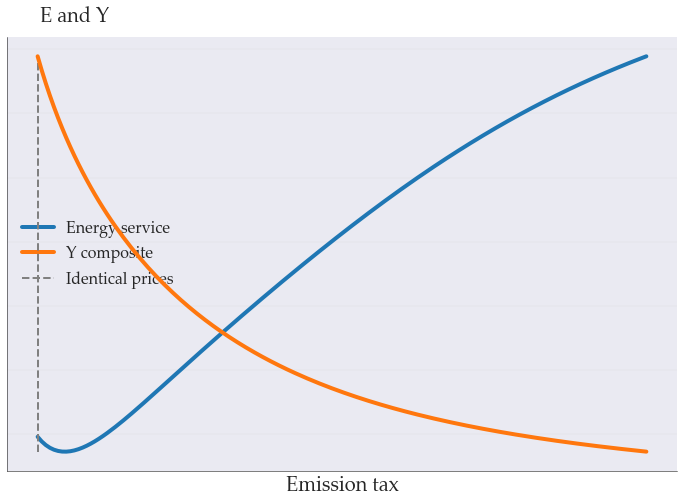

In [35]:
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 1, 1)
ax = fig.get_axes()[0]
col = "qD_EL"
assert col in df.columns
ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[0])
ax2 = ax.twinx()
col = "qD_Y"
assert col in df.columns
ax2.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[1])
ax2.vlines(x=vlines, ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2, label="Identical prices")
lines, labels = ax.get_legend_handles_labels()
lines = lines + ax2.get_legend_handles_labels()[0]
labels = labels + ax2.get_legend_handles_labels()[1]
ax.legend(lines, labels, fontsize=16, loc="center left")
format_double_axes(ax, ax2, "Emission tax", "E and Y", hide_ticks=True)
# fig.savefig("oil_" + catalog + ".pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')
del fig, ax, ax2

Figure number 3, electricity

AssertionError: 

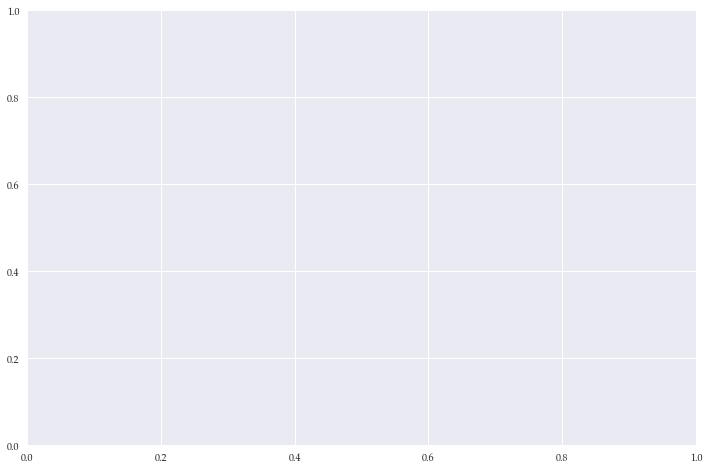

In [17]:
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 1, 1)
ax = fig.get_axes()[0]
col = "qD_basetech_EL_electricity"
assert col in df.columns
ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color=colors[0])
ax.vlines(x=vlines, ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2)
format_single_axis(ax, x_label=translate(df.index.name), y_label=translate(col))
fig.savefig("electricity_" + catalog + ".pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')
del fig, ax
#Da der var 2 serier:
# ax.plot(df.index, col, data=df, label=translate(col) + ", EOP", linewidth=4, color="#1f77b4")
# ax2 = ax.twinx()
# ax2.plot(dfID.index, col, data=dfID, label=translate(col) + ", ID", linewidth=4, color="#ff770e")
# ax.vlines(x=[6.5, 10], ymin=dfEOP[col].min(), ymax=dfEOP[col].max(), ls='--', color="grey", lw=2)
# lines, labels = ax.get_legend_handles_labels()
# lines = lines + ax2.get_legend_handles_labels()[0]
# labels = labels + ax2.get_legend_handles_labels()[1]
# ax.legend(lines, labels, fontsize=16, loc="right")
# format_double_axes(ax, ax2, x_label=translate(df.index.name), y_label=translate(col))